In [2]:
# Beware of whitespace issues
import pandas as pd
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices
import csv
import scipy.stats as s
import matplotlib.pyplot as plt

Normality test rater1: NormaltestResult(statistic=np.float64(17807.487876428764), pvalue=np.float64(0.0))
Normality test rater2: NormaltestResult(statistic=np.float64(16465.879873231916), pvalue=np.float64(0.0))


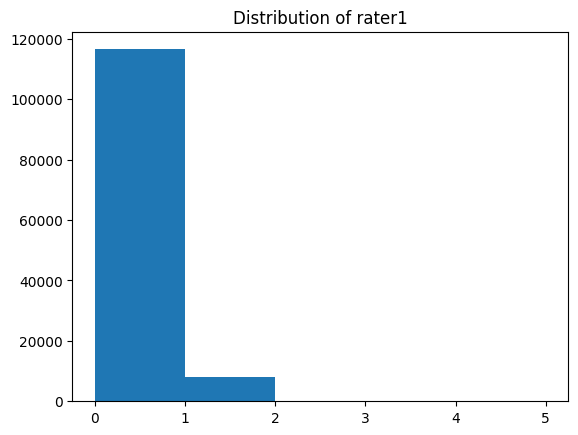

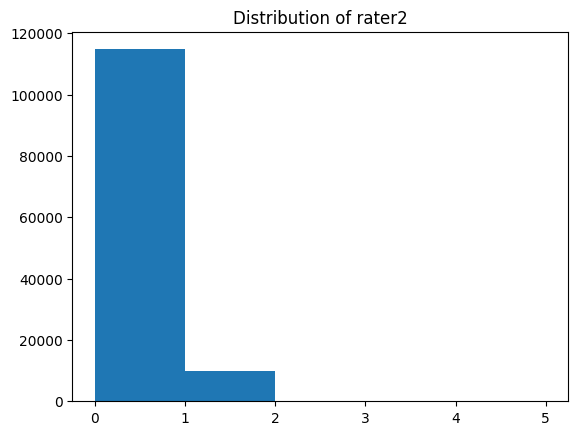

Spearman correlation: SignificanceResult(statistic=np.float64(0.8576416920986697), pvalue=np.float64(0.0))


In [9]:

def test_ratings():
    """Check correlation between rater1 and rater2 scores."""

    # Load data & create list of dicts
    with open('../../DATA/CrowdstormingDataJuly1st.csv', 'r') as f:
        data_reader = csv.DictReader(f)
        data = [row for row in data_reader]

    # Check IRR of ratings
    rater1 = [float(row["rater1"]) for row in data if "NA" not in [row["rater1"], row["rater2"]]]
    rater2 = [float(row["rater2"]) for row in data if "NA" not in [row["rater1"], row["rater2"]]]

    # Normality tests
    print("Normality test rater1:", s.normaltest(rater1, axis=0))
    print("Normality test rater2:", s.normaltest(rater2, axis=0))

    # Histograms
    plt.figure(1)
    plt.hist(rater1, bins=5, range=(0, 5))
    plt.title("Distribution of rater1")

    plt.figure(2)
    plt.hist(rater2, bins=5, range=(0, 5))
    plt.title("Distribution of rater2")

    plt.show()

    # Spearman correlation (non-parametric)
    print("Spearman correlation:", s.spearmanr(rater1, rater2))


# Uncomment to test
test_ratings()

# ==========================================================
# Load dataset
# ==========================================================

In [16]:
df = pd.read_csv("../../DATA/CrowdstormingDataJuly1st.csv")

keys = [
    'playerShort', 'refNum', 'games', 'goals', 'yellowCards', 'redCards',
    'meanIAT', 'meanExp', 'rater1', 'rater2'
]
df = df[keys]

# Drop NA ratings and compute average rating
df = df.dropna(subset=['rater1', 'rater2'])
df['rating'] = (df['rater1'] + df['rater2']) / 2

# Convert IAT and Exp to percentages
df['meanIAT'] = df['meanIAT'] * 100
df['meanExp'] = df['meanExp'] * 100

# Check variance and mean for Poisson suitability
print("Variance:", df['redCards'].var())
print("Mean:", df['redCards'].mean())

Variance: 0.012973352601975727
Mean: 0.012750660001123406


# ==========================================================
# QUESTION 1
# ==========================================================

In [11]:
print("\nQUESTION 1")

# Define model
y, X = dmatrices(
    'redCards ~ rating + rating*games + rating*goals + rating*yellowCards + rating*meanIAT + rating*meanExp',
    data=df,
    return_type='dataframe'
)

# Poisson regression
poisson_mod = sm.Poisson(y, X)
poisson_res = poisson_mod.fit()
print(poisson_res.summary())


QUESTION 1
Optimization terminated successfully.
         Current function value: 0.064567
         Iterations 11
                          Poisson Regression Results                          
Dep. Variable:               redCards   No. Observations:               124468
Model:                        Poisson   Df Residuals:                   124456
Method:                           MLE   Df Model:                           11
Date:                Mon, 10 Nov 2025   Pseudo R-squ.:                 0.05843
Time:                        09:12:32   Log-Likelihood:                -8036.5
converged:                       True   LL-Null:                       -8535.2
Covariance Type:            nonrobust   LLR p-value:                6.988e-207
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -7.2560      0.677    -10.716      0.000      -8.583     

Question 1:  A regression coefficient of 1.0757 was found for skin-tone rating.  This 
result can be exponentiated into an incidence rate ratio of  2.9321.  This incidence rate ratio can 
be interpreted as “a player with the darkest skin tone is 2.9321 times as likely to receive a red 
card than a player with the lightest skin tone”.  However, this finding 
is of little value, given the 
wide confidence intervals (95% conf: [0.1085, 78.6596]) and high p-value 
(p 
= 0.5266)
.

# ==========================================================
# QUESTION 2a — effect of meanIAT
# ==========================================================

In [13]:
print("\nQUESTION 2a")

print("len pre-drop:", len(df))
df_2a = df.dropna(subset=['meanIAT'])
print("len post-drop:", len(df_2a))

y, X = dmatrices(
    'redCards ~ meanIAT + meanIAT*rating + meanIAT*games + meanIAT*goals + meanIAT*yellowCards + meanIAT*meanExp',
    data=df_2a,
    return_type='dataframe'
)

poisson_mod = sm.Poisson(y, X)
poisson_res = poisson_mod.fit()
print(poisson_res.summary())


QUESTION 2a
len pre-drop: 124621
len post-drop: 124468
Optimization terminated successfully.
         Current function value: 0.064175
         Iterations 12
                          Poisson Regression Results                          
Dep. Variable:               redCards   No. Observations:               124468
Model:                        Poisson   Df Residuals:                   124456
Method:                           MLE   Df Model:                           11
Date:                Mon, 10 Nov 2025   Pseudo R-squ.:                 0.06414
Time:                        09:12:58   Log-Likelihood:                -7987.7
converged:                       True   LL-Null:                       -8535.2
Covariance Type:            nonrobust   LLR p-value:                6.904e-228
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -6.7871   

Question 2:  A regression coefficient of -4.1810 was found for the interaction term of 
rating and meanIAT.  This result can be exponentiated into an incidence rate ratio of  0.0153.  
This finding was also not significant (95% conf: [.0000, 466.2143], 
p 
= 0.4355).

# ==========================================================
# QUESTION 2b — effect of meanExp
# ==========================================================

In [14]:
print("\nQUESTION 2b")

print("len pre-drop:", len(df))
df_2b = df.dropna(subset=['meanExp'])
print("len post-drop:", len(df_2b))

y, X = dmatrices(
    'redCards ~ meanExp + meanExp*rating + meanExp*games + meanExp*goals + meanExp*yellowCards + meanExp*meanIAT',
    data=df_2b,
    return_type='dataframe'
)

poisson_mod = sm.Poisson(y, X)
poisson_res = poisson_mod.fit()
print(poisson_res.summary())



QUESTION 2b
len pre-drop: 124621
len post-drop: 124468
Optimization terminated successfully.
         Current function value: 0.064234
         Iterations 12
                          Poisson Regression Results                          
Dep. Variable:               redCards   No. Observations:               124468
Model:                        Poisson   Df Residuals:                   124456
Method:                           MLE   Df Model:                           11
Date:                Mon, 10 Nov 2025   Pseudo R-squ.:                 0.06328
Time:                        09:13:04   Log-Likelihood:                -7995.1
converged:                       True   LL-Null:                       -8535.2
Covariance Type:            nonrobust   LLR p-value:                1.052e-224
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -7.4913   

Question 3:  A regression coefficient of 0.5723 was found for the interaction term of 
rating and meanExp.  This result can be exponentiated into an incidence rate ratio of 1.7724.  
This effect was not significant (95% conf: [0.3820, 8.0215], 
p
 = 0.4661).